# Методы отбора признаков

На лекции были рассказаны разные алгоритмы отбора признаков, которые, в теории, можно использовать:
* полный перебор
* жадный алгоритм
* поиск в ширину
* эволюционный алгоритм

Однако, на практике дела обстоят немного иначе.

В sklearn есть пачка отличных методов отбора признаков: https://scikit-learn.org/stable/modules/feature_selection.html

О них сегодня и поговорим.

In [118]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Работать будем с [датасетом](https://yadi.sk/i/GL_fENYfQbqOFQ) про больных, у которых опухоль груди. Будем определять, доброкачественная она или злокачественная:

In [119]:
data = pd.read_csv('data.csv').set_index('id')
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [120]:
data.shape

(569, 31)

Немножечко подготовим данные:

In [121]:
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

Разобьём на обучающую и тестовую выборку:

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

Сегодня нашим подопытным будет Random Forest, а измерять будем Accuracy:

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def predict_with_random_forest(X_train, y_train, X_test, y_test):
    regression = RandomForestClassifier(n_estimators=100, random_state=17)
    regression.fit(X_train, y_train)
    predicted_y = regression.predict(X_test)
    return accuracy_score(y_test, predicted_y)

print (predict_with_random_forest(X_train, y_train, X_test, y_test))

0.9468085106382979


### Variance Threshold

Самый простой метод. Просто удаляем признаки с маленькой дисперсией:

In [124]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1e-3)
selector.fit(X)
X_train_filtered = selector.transform(X_train)
X_test_filtered = selector.transform(X_test)

print (X_train_filtered.shape)
print (predict_with_random_forest(X_train_filtered, y_train, X_test_filtered, y_test))

(381, 19)
0.9627659574468085


### Удаление слишком коррелированных признаков

Давайте посмотрим на матрицу корреляции:

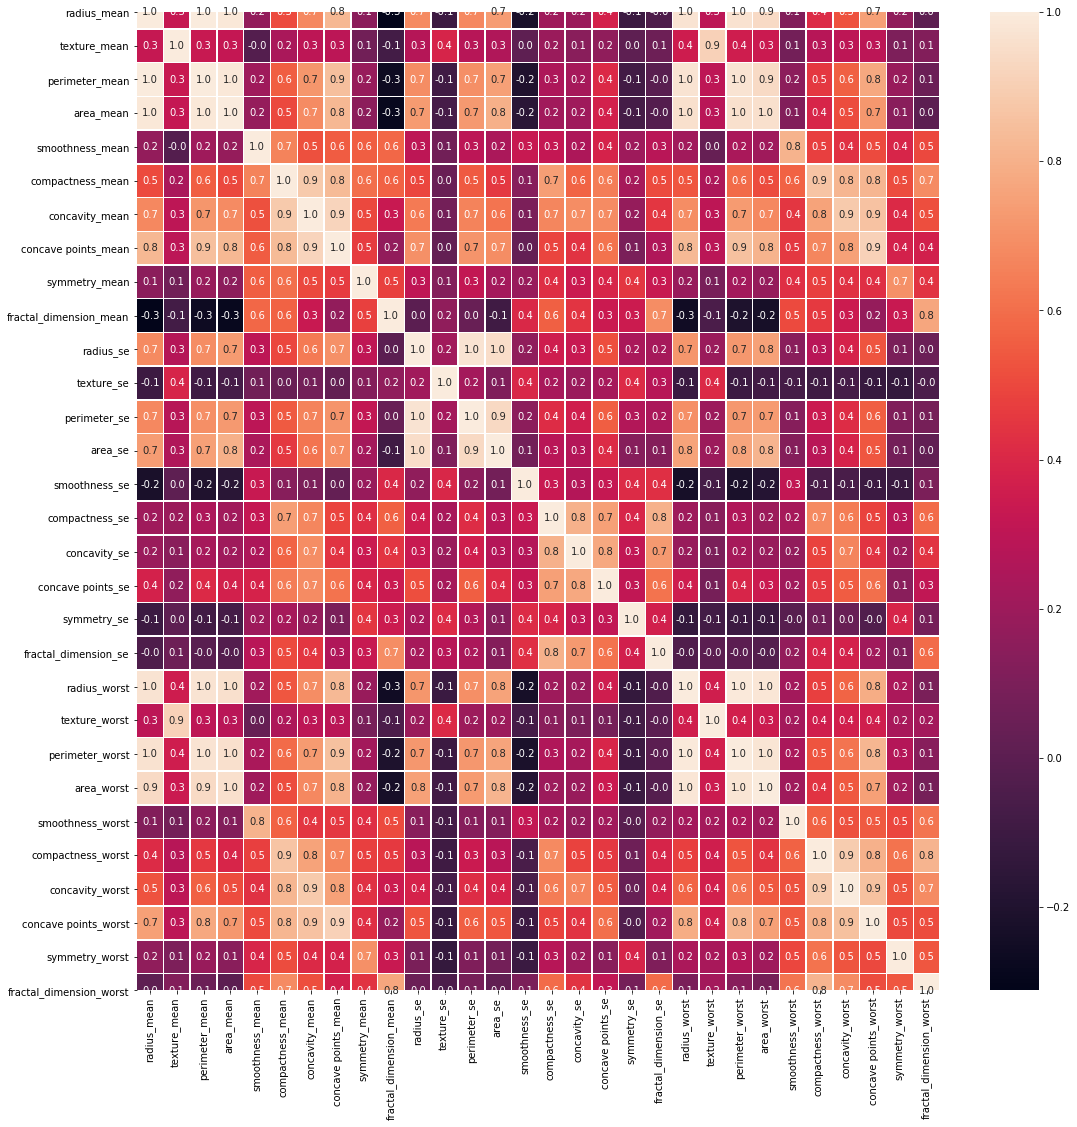

In [125]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Можно заметить ряд белых клеток с корреляцией 1. Когда у нас признаки полностью коррелируют, то модели бывает сложно обучаться, а информации это никакой не несёт.

Давайте из всех признаков с попарной корреляцией 1 оставим только единственный экземпляр:

In [126]:
drop_list = ['perimeter_mean', 'radius_mean', 'compactness_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'radius_worst', 'perimeter_worst', 'compactness_worst', 'concave points_worst', 'compactness_se', 'concave points_se', 'texture_worst', 'area_worst']
X_train_filtered = X_train.drop(drop_list, axis = 1)
X_test_filtered = X_test.drop(drop_list, axis = 1)

predict_with_random_forest(X_train_filtered, y_train, X_test_filtered, y_test)

0.973404255319149

**Задание 1 (0.5 балла).** Я выбрал признаки с коррелицией "на глазок". Давайте лучше определим, какие признаки оставлять, а какие удалять из-за высокой корреляции, алгоритмически.

Будем удалять такие колонки, у которых выше главной диагонали встречаются значения >= 0.9. При этом, будем перестраивать матрицу корреляции после каждого удаления.

In [127]:
def clean_corr(data, threshold):
    to_drop = []
    
    corr = data.corr(method = 'pearson').abs().round(1)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    get_out_cols = [col for col in upper.columns if any(upper[col] >= threshold)]
    
    while (get_out_cols):
        get_out_col = get_out_cols[0]
        to_drop.append(get_out_col)
        
        corr = data.drop(to_drop, axis=1).corr(method = 'pearson').abs().round(1)
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
        get_out_cols = [col for col in upper.columns if any(upper[col] >= threshold)]
    return to_drop

In [128]:
threshold = 0.9
my_drop_list = clean_corr(X, threshold)
print(len(my_drop_list))
print(my_drop_list)

11
['perimeter_mean', 'area_mean', 'concavity_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concave points_worst']


In [106]:
assert(len(my_drop_list) == len(drop_list))

AssertionError: 

### Univariate feature selection

С помощью метода SelectKBest можно выбрать лучшие признаки по какому-нибудь параметру. Например, используем критерий хи-квадрат для отбора:

In [129]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=25)
selector.fit(X_train, y_train)
X_train_filtered = selector.transform(X_train)
X_test_filtered = selector.transform(X_test)

predict_with_random_forest(X_train_filtered, y_train, X_test_filtered, y_test)

0.9627659574468085

### Recursive Feature Elimination (RFE)

Возьмём какой-нибудь алгоритм, который присваивает веса признакам. И будем удалять признаки с самым маленьким весом. Где-то мы уже это видели... Где?

In [130]:
from sklearn.feature_selection import RFE

base_clf = RandomForestClassifier(n_estimators=100)      
rfe = RFE(estimator=base_clf, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

In [131]:
print('Chosen best 5 feature by rfe:', X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst'],
      dtype='object')


Тем не менее, всё ещё остаётся одна проблема. Как выбрать количество признаков, которые мы хотим отобрать?

**Задание 2 (1 балл).** Заиспользуйте https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html, который делает RFE и использует кросс-валидацию для поиска оптимального значения количества признаков. Постройте график зависимости качества на кросс-валидации от количества признаков.

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [132]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
base_clf = RandomForestClassifier(n_estimators=100)
rfe_cv = RFECV(base_clf, step=1, min_features_to_select=1, n_jobs=-1, cv=kf, scoring='accuracy')
rfe_cv = rfe_cv.fit(X_train, y_train)

Optimal number of features : 21


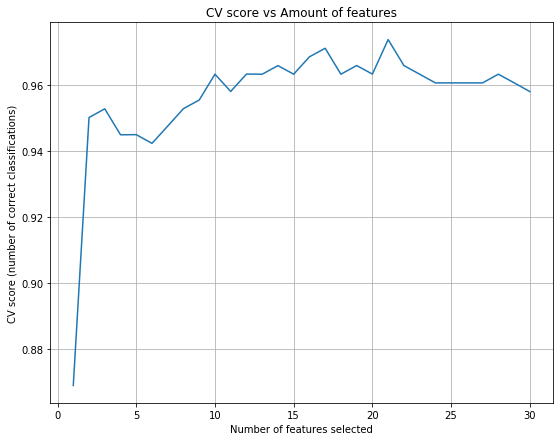

In [133]:
print(f'Optimal number of features : {rfe_cv.n_features_}')

plt.figure(figsize=(9, 7))
plt.title('CV score vs Amount of features')
plt.xlabel("Number of features selected")
plt.ylabel("CV score (number of correct classifications)")
plt.plot(range(1, len(rfe_cv.grid_scores_) + 1), rfe_cv.grid_scores_)
plt.grid()
plt.show()

### Полезные ссылки

* https://github.com/scikit-learn-contrib/boruta_py - Boruta
* https://www.kaggle.com/ogrellier/feature-selection-with-null-importances - Null importances

# Методы работы с пропущенными значениями

Почему на практике возникают пропущенные значения очень понятно:
* сломался сенсор
* ошибка парсинга
* данные потерялись
* ваш вариант

Пропущенные признаки бывают разных типов:
* MCAP - missing completely at random - вероятность пропуска не зависит от значений наблюдаемых и пропущенных данных
* MAR - missing at random - вероятность пропуска зависит от значений наблюдаемых, но не от значений пропущенных данных
* MNAR - missing not at random - вероятность пропуска зависит от значений и наблюдаемых, и пропущенных данных

## Как же бороться?

Начнём с простого:
* удалить объекты с пропущенным значением
* удалить признаки с пропущенными значениями
* заменить специальным значением
* заменить средним/медианой/модой
* LOCF - Last Observation Carried Forward
* FOCB - First Observation Carried Backward

Но есть и более интересные варианты.

### kNN

Плюсы:
* высокая точность
* обобщается на категориальные признаки

Минусы:
* нужно настраивать кучу параметров
* нужно много данных без пропусков

### Кластеризация

Аналогично kNN, но считаем среднее по кластеру.

### Предсказание пропущенных значений

* Используем признак с пропущенными значениями как целевую переменную
* Обучаемся на объектах с известными значениями
* Предсказываем для объектов с неизвестными

### MICE - Multiple Imputation by Chained Equations

* Инициализируем пропущенные значения чем-то простым (например, средним)
* Для каждого пропущенного признака обучаемся на всей выборке, выкидывая его
* Повторяем предыдущий щаг до сходимости (пока значения пропущенных признаков не перестают меняться)

Плюсы:
* высокое качество

Минусы:
* нужно настраивать модель
* может долго работать

### SVD - Singular value decomposition

Плюсы:
* используем все данные для восстановления значений 
Минусы:
* нужно настраивать SVD
* может долго работать

Независимо от признака совет: для признака с пропусками добавить отдельную переменную, которая говорит, было ли значение изначально

## На практике

Давайте попробуем сравнить ряд этих методов с помощью библиотеки fancyimpute (https://github.com/iskandr/fancyimpute).

**Задание 3 (1.5 балла).** Будем пытаться повторить результаты из статьи https://www.omicsonline.org/open-access/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.pdf.

План такой:
* удалять случайным образом некоторую часть значений
* использовать методы для восстановления данных
* для каждого метода восстановления строить график зависимости RMSE между реальными и предсказанными признаками от доли пропущенных значений

Исследуйте следующие методы:
* замена средним (SimpleFill)
* замена медианой (SimpleFill)
* kNN (KNN)
* SVD (IterativeSVD)
* MICE (IterativeImputer)

Датасет всё тот же, что и выше: про больных опухолью груди. 

**Важно!**:
* т.к. некоторые методы работают очень долго, рекомендуется взять небольшую часть датасета (ну, пускай 100 образцов)
* не забудьте отмасштабировать признаки, а то у вас получится RMSE, составленное из яблок, песка и небесного полотна

In [134]:
X.shape

(569, 30)

In [135]:
X_missing = pd.DataFrame(X.iloc[:150])
X_missing.shape

(150, 30)

In [136]:
X_missing.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(X_missing)
X_missing = pd.DataFrame(scaler.transform(X_missing), columns=X_missing.columns, index=X_missing.index)
X_full = pd.DataFrame(X_missing)

In [139]:
X_missing.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1.077499,-2.346689,1.233250,1.028788,1.196672,2.668117,2.281387,2.239779,1.697087,1.826667,...,1.806440,-1.511210,2.194265,2.051428,0.931805,1.980749,1.693136,1.972560,1.888954,1.371133
842517,1.839721,-0.358213,1.664093,2.039975,-1.215591,-0.719538,-0.257541,0.282673,-0.287880,-1.011537,...,1.723409,-0.434927,1.415280,1.931796,-0.723736,-0.629656,-0.387512,0.780827,-0.484087,-0.017317
84300903,1.579738,0.578174,1.540385,1.657280,0.566015,0.664061,1.058367,1.751330,0.552543,-0.584004,...,1.421091,-0.059644,1.225063,1.462765,0.164393,0.666827,0.536237,1.636353,0.622307,-0.084230
84348301,-0.863509,0.344077,-0.695729,-0.884380,2.923812,2.775386,1.582348,1.173839,2.279170,4.238625,...,-0.422622,0.112066,-0.394198,-0.704465,2.983986,3.074503,1.582534,1.853987,4.500452,3.885026
84358402,1.756999,-1.281146,1.757939,1.949746,-0.100475,0.202634,1.065512,1.150943,-0.297691,-0.733383,...,1.201804,-1.628044,1.216005,1.208310,-0.137398,-0.529381,0.313263,0.428110,-0.978951,-0.586079


In [140]:
nan_mask = np.random.random(X_missing.shape)<0.2
print(f'Percentage of NA in data(for col): {nan_mask.sum(axis=0)/150}')

Percentage of NA in data(for col): [0.12       0.16       0.18666667 0.21333333 0.21333333 0.18
 0.3        0.24       0.26666667 0.24666667 0.20666667 0.23333333
 0.24666667 0.21333333 0.21333333 0.11333333 0.2        0.23333333
 0.19333333 0.18666667 0.19333333 0.20666667 0.18       0.18666667
 0.18666667 0.18666667 0.27333333 0.19333333 0.19333333 0.16666667]


In [142]:
X_missing = X_missing.mask(nan_mask)
X_missing.isna().sum(axis=0)

radius_mean                18
texture_mean               24
perimeter_mean             28
area_mean                  32
smoothness_mean            32
compactness_mean           27
concavity_mean             45
concave points_mean        36
symmetry_mean              40
fractal_dimension_mean     37
radius_se                  31
texture_se                 35
perimeter_se               37
area_se                    32
smoothness_se              32
compactness_se             17
concavity_se               30
concave points_se          35
symmetry_se                29
fractal_dimension_se       28
radius_worst               29
texture_worst              31
perimeter_worst            27
area_worst                 28
smoothness_worst           28
compactness_worst          28
concavity_worst            41
concave points_worst       29
symmetry_worst             29
fractal_dimension_worst    25
dtype: int64

In [143]:
def count_rmse(X_full, X_missing):
    return np.sqrt(((X_full.values - X_missing) ** 2).mean())

In [144]:
from fancyimpute import KNN, SimpleFill, IterativeImputer, IterativeSVD

results = [[], [], [], [], []]

for upper_bound in np.linspace(0.05, 0.45, 9):
    nan_mask = np.random.random(X_missing.shape) < upper_bound
    
    X_missing = X_full.mask(nan_mask)
    
    X_filled_mean = SimpleFill(fill_method='mean').fit_transform(X_missing)
    X_filled_median = SimpleFill(fill_method='median').fit_transform(X_missing)
    X_filled_knn = KNN(k=3).fit_transform(X_missing)
    X_filled_SVD = IterativeSVD().fit_transform(X_missing)
    X_filled_mice = IterativeImputer().fit_transform(X_missing)
    
    results[0].append(count_rmse(X_full, X_filled_mean))
    results[1].append(count_rmse(X_full, X_filled_median))
    results[2].append(count_rmse(X_full, X_filled_knn))
    results[3].append(count_rmse(X_full, X_filled_SVD))
    results[4].append(count_rmse(X_full, X_filled_mice))

Imputing row 1/150 with 0 missing, elapsed time: 0.009
Imputing row 101/150 with 2 missing, elapsed time: 0.013
[IterativeSVD] Iter 1: observed MAE=0.523128
[IterativeSVD] Iter 2: observed MAE=0.402386
[IterativeSVD] Iter 3: observed MAE=0.294751
[IterativeSVD] Iter 4: observed MAE=0.190577
[IterativeSVD] Iter 5: observed MAE=0.149704
[IterativeSVD] Iter 6: observed MAE=0.148399
[IterativeSVD] Iter 7: observed MAE=0.147996
[IterativeSVD] Iter 8: observed MAE=0.147851
[IterativeSVD] Iter 9: observed MAE=0.147811
[IterativeSVD] Iter 10: observed MAE=0.147801
[IterativeSVD] Iter 11: observed MAE=0.147805
[IterativeSVD] Iter 12: observed MAE=0.147812
[IterativeSVD] Iter 13: observed MAE=0.147820
[IterativeSVD] Iter 14: observed MAE=0.147827
[IterativeSVD] Iter 15: observed MAE=0.147832
[IterativeSVD] Iter 16: observed MAE=0.147836
[IterativeSVD] Iter 17: observed MAE=0.147841
[IterativeSVD] Iter 18: observed MAE=0.147846
[IterativeSVD] Iter 19: observed MAE=0.147851
[IterativeSVD] Iter 20:

/usr/local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/150 with 5 missing, elapsed time: 0.009
Imputing row 101/150 with 1 missing, elapsed time: 0.014
[IterativeSVD] Iter 1: observed MAE=0.523775
[IterativeSVD] Iter 2: observed MAE=0.402622
[IterativeSVD] Iter 3: observed MAE=0.297336
[IterativeSVD] Iter 4: observed MAE=0.188015
[IterativeSVD] Iter 5: observed MAE=0.147668
[IterativeSVD] Iter 6: observed MAE=0.144088
[IterativeSVD] Iter 7: observed MAE=0.142534
[IterativeSVD] Iter 8: observed MAE=0.141685
[IterativeSVD] Iter 9: observed MAE=0.141104
[IterativeSVD] Iter 10: observed MAE=0.140683
[IterativeSVD] Iter 11: observed MAE=0.140365
[IterativeSVD] Iter 12: observed MAE=0.140135
[IterativeSVD] Iter 13: observed MAE=0.139946
[IterativeSVD] Iter 14: observed MAE=0.139787
[IterativeSVD] Iter 15: observed MAE=0.139650
[IterativeSVD] Iter 16: observed MAE=0.139530
[IterativeSVD] Iter 17: observed MAE=0.139422
[IterativeSVD] Iter 18: observed MAE=0.139322
[IterativeSVD] Iter 19: observed MAE=0.139237
[IterativeSVD] Iter 20:

/usr/local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/150 with 4 missing, elapsed time: 0.009
Imputing row 101/150 with 6 missing, elapsed time: 0.018
[IterativeSVD] Iter 1: observed MAE=0.529872
[IterativeSVD] Iter 2: observed MAE=0.406287
[IterativeSVD] Iter 3: observed MAE=0.299255
[IterativeSVD] Iter 4: observed MAE=0.193465
[IterativeSVD] Iter 5: observed MAE=0.151139
[IterativeSVD] Iter 6: observed MAE=0.145668
[IterativeSVD] Iter 7: observed MAE=0.143358
[IterativeSVD] Iter 8: observed MAE=0.142151
[IterativeSVD] Iter 9: observed MAE=0.141373
[IterativeSVD] Iter 10: observed MAE=0.140824
[IterativeSVD] Iter 11: observed MAE=0.140409
[IterativeSVD] Iter 12: observed MAE=0.140066
[IterativeSVD] Iter 13: observed MAE=0.139781
[IterativeSVD] Iter 14: observed MAE=0.139530
[IterativeSVD] Iter 15: observed MAE=0.139311
[IterativeSVD] Iter 16: observed MAE=0.139108
[IterativeSVD] Iter 17: observed MAE=0.138924
[IterativeSVD] Iter 18: observed MAE=0.138752
[IterativeSVD] Iter 19: observed MAE=0.138587
[IterativeSVD] Iter 20:

/usr/local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/150 with 10 missing, elapsed time: 0.014
Imputing row 101/150 with 4 missing, elapsed time: 0.026
[IterativeSVD] Iter 1: observed MAE=0.542714
[IterativeSVD] Iter 2: observed MAE=0.415880
[IterativeSVD] Iter 3: observed MAE=0.302464
[IterativeSVD] Iter 4: observed MAE=0.193524
[IterativeSVD] Iter 5: observed MAE=0.152532
[IterativeSVD] Iter 6: observed MAE=0.144994
[IterativeSVD] Iter 7: observed MAE=0.141270
[IterativeSVD] Iter 8: observed MAE=0.138893
[IterativeSVD] Iter 9: observed MAE=0.137266
[IterativeSVD] Iter 10: observed MAE=0.135985
[IterativeSVD] Iter 11: observed MAE=0.135050
[IterativeSVD] Iter 12: observed MAE=0.134262
[IterativeSVD] Iter 13: observed MAE=0.133633
[IterativeSVD] Iter 14: observed MAE=0.133101
[IterativeSVD] Iter 15: observed MAE=0.132640
[IterativeSVD] Iter 16: observed MAE=0.132248
[IterativeSVD] Iter 17: observed MAE=0.131925
[IterativeSVD] Iter 18: observed MAE=0.131625
[IterativeSVD] Iter 19: observed MAE=0.131353
[IterativeSVD] Iter 20

/usr/local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/150 with 4 missing, elapsed time: 0.011
Imputing row 101/150 with 6 missing, elapsed time: 0.023
[IterativeSVD] Iter 1: observed MAE=0.543948
[IterativeSVD] Iter 2: observed MAE=0.419532
[IterativeSVD] Iter 3: observed MAE=0.309098
[IterativeSVD] Iter 4: observed MAE=0.195873
[IterativeSVD] Iter 5: observed MAE=0.151097
[IterativeSVD] Iter 6: observed MAE=0.142818
[IterativeSVD] Iter 7: observed MAE=0.138571
[IterativeSVD] Iter 8: observed MAE=0.135981
[IterativeSVD] Iter 9: observed MAE=0.134158
[IterativeSVD] Iter 10: observed MAE=0.132881
[IterativeSVD] Iter 11: observed MAE=0.131952
[IterativeSVD] Iter 12: observed MAE=0.131292
[IterativeSVD] Iter 13: observed MAE=0.130764
[IterativeSVD] Iter 14: observed MAE=0.130310
[IterativeSVD] Iter 15: observed MAE=0.129918
[IterativeSVD] Iter 16: observed MAE=0.129585
[IterativeSVD] Iter 17: observed MAE=0.129292
[IterativeSVD] Iter 18: observed MAE=0.129032
[IterativeSVD] Iter 19: observed MAE=0.128799
[IterativeSVD] Iter 20:

/usr/local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/150 with 10 missing, elapsed time: 0.010
Imputing row 101/150 with 10 missing, elapsed time: 0.025
[IterativeSVD] Iter 1: observed MAE=0.547389
[IterativeSVD] Iter 2: observed MAE=0.415216
[IterativeSVD] Iter 3: observed MAE=0.308094
[IterativeSVD] Iter 4: observed MAE=0.197182
[IterativeSVD] Iter 5: observed MAE=0.148345
[IterativeSVD] Iter 6: observed MAE=0.137822
[IterativeSVD] Iter 7: observed MAE=0.132790
[IterativeSVD] Iter 8: observed MAE=0.129611
[IterativeSVD] Iter 9: observed MAE=0.127321
[IterativeSVD] Iter 10: observed MAE=0.125611
[IterativeSVD] Iter 11: observed MAE=0.124388
[IterativeSVD] Iter 12: observed MAE=0.123451
[IterativeSVD] Iter 13: observed MAE=0.122716
[IterativeSVD] Iter 14: observed MAE=0.122087
[IterativeSVD] Iter 15: observed MAE=0.121540
[IterativeSVD] Iter 16: observed MAE=0.121036
[IterativeSVD] Iter 17: observed MAE=0.120576
[IterativeSVD] Iter 18: observed MAE=0.120164
[IterativeSVD] Iter 19: observed MAE=0.119793
[IterativeSVD] Iter 2

/usr/local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing row 1/150 with 16 missing, elapsed time: 0.011
Imputing row 101/150 with 18 missing, elapsed time: 0.035
[IterativeSVD] Iter 1: observed MAE=0.580741
[IterativeSVD] Iter 2: observed MAE=0.447110
[IterativeSVD] Iter 3: observed MAE=0.317562
[IterativeSVD] Iter 4: observed MAE=0.205388
[IterativeSVD] Iter 5: observed MAE=0.148232
[IterativeSVD] Iter 6: observed MAE=0.131330
[IterativeSVD] Iter 7: observed MAE=0.122321
[IterativeSVD] Iter 8: observed MAE=0.116824
[IterativeSVD] Iter 9: observed MAE=0.112924
[IterativeSVD] Iter 10: observed MAE=0.109907
[IterativeSVD] Iter 11: observed MAE=0.107511
[IterativeSVD] Iter 12: observed MAE=0.105442
[IterativeSVD] Iter 13: observed MAE=0.103666
[IterativeSVD] Iter 14: observed MAE=0.102137
[IterativeSVD] Iter 15: observed MAE=0.100786
[IterativeSVD] Iter 16: observed MAE=0.099562
[IterativeSVD] Iter 17: observed MAE=0.098488
[IterativeSVD] Iter 18: observed MAE=0.097524
[IterativeSVD] Iter 19: observed MAE=0.096681
[IterativeSVD] Iter 2

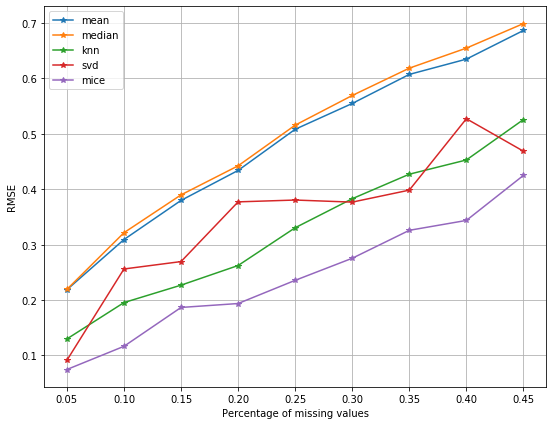

In [145]:
plt.figure(figsize=(9, 7))
plt.xlabel("Percentage of missing values")
plt.ylabel("RMSE")
plt.plot(np.linspace(0.05, 0.45, 9), results[0], marker='*')
plt.plot(np.linspace(0.05, 0.45, 9), results[1], marker='*')
plt.plot(np.linspace(0.05, 0.45, 9), results[2], marker='*')
plt.plot(np.linspace(0.05, 0.45, 9), results[3], marker='*')
plt.plot(np.linspace(0.05, 0.45, 9), results[4], marker='*')
plt.legend(['mean', 'median', 'knn', 'svd','mice'])
plt.grid()
plt.show()

Видно по графику, что наименьшую ошибку для всех пропорций пропущенных значений показывает метод MICE.